In [12]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from sklearn import datasets
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Reading the dataset

In [13]:
data = pd.read_csv("YS01 - ML Photocatalysis Transitional Metals.csv")
print(data.shape)
data.head()

(49, 25)


,Index,Catalyst,Catalyst amount (umol),mmol CO / g QD,pH before,Time,mass (um),Charge,radius (pm),Number of electrons,...,3->2,Electronegativity,Density,Melting point,Electical Conductivity 10^7,Thermal Conductivity,Magnetic Type,Extinction coefficient,Max absorption wavelength,Extinction coefficient (400 nm)
0,1,FeCl3,0.0002,11.28,NaN,24.0,55.845,3,64.5,26,...,0.771,1.8,2.9,579.1,1.0,79.0,Ferromagnetic,1840,292,53.5
1,2,FeCl3,0.0020,33.84,NaN,24.0,55.845,3,64.5,26,...,0.771,1.8,2.9,579.1,1.0,79.0,Ferromagnetic,1840,292,53.5
2,3,FeCl3,0.0100,71.57,NaN,24.0,55.845,3,64.5,26,...,0.771,1.8,2.9,579.1,1.0,79.0,Ferromagnetic,1840,292,53.5
3,4,FeCl3,0.2000,452.21,NaN,24.0,55.845,3,64.5,26,...,0.771,1.8,2.9,579.1,1.0,79.0,Ferromagnetic,1840,292,53.5
4,5,FeCl3,1.0000,243.69,NaN,24.0,55.845,3,64.5,26,...,0.771,1.8,2.9,579.1,1.0,79.0,Ferromagnetic,1840,292,53.5


# Preprocessing

In [14]:
catalyst_encoder = LabelEncoder()
type_encoder = LabelEncoder()

data.drop(['Index'],axis=1,inplace=True)

data['Catalyst'] = catalyst_encoder.fit_transform(data['Catalyst'])
label_mapping = dict(zip(catalyst_encoder.classes_, catalyst_encoder.transform(catalyst_encoder.classes_)))
print(label_mapping)

data.drop(['Catalyst'],axis=1,inplace=True)
data['mmol CO / g QD'] = data['mmol CO / g QD'] / data['Time ']
data.drop(['Time '],axis=1,inplace=True)

data['Type of complex (low-spin vs high-spin)'] = catalyst_encoder.fit_transform(data['Type of complex (low-spin vs high-spin)'])

data['Magnetic Type'] = type_encoder.fit_transform(data['Magnetic Type'])
label_mapping = dict(zip(type_encoder.classes_, type_encoder.transform(type_encoder.classes_)))
print(label_mapping)
data = data.fillna(0)

features_scaler = StandardScaler()
target_scaler = StandardScaler()

data_pipeline = Pipeline([
        ('std_scaler', features_scaler),
    ])

target_pipeline = Pipeline([
        ('std_scaler', target_scaler),
    ])

target = data['mmol CO / g QD']
features = data.drop('mmol CO / g QD', axis=1)

columns_f = features.columns

features = data_pipeline.fit_transform(features)
features = pd.DataFrame(features,columns=columns_f)

target = data_pipeline.fit_transform(target.to_numpy().reshape(-1,1))
target = pd.DataFrame(target,columns=['mmol CO / g QD'])

{'CoCl2': 0, 'FeCl2': 1, 'FeCl3': 2, 'MnCl2': 3, 'ZnAc2': 4, 'ZnCl2': 5}
{'Diamagnetic': 0, 'Ferromagnetic': 1, 'Paramagnetic': 2}


# Splitting the dataset 

In [15]:
x_train, X_test, y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [16]:
def objective_function(params):
    model = xgb.XGBRegressor(objective='reg:squarederror', params = params[0])
    scores = cross_val_score(model, x_train, y_train, cv=5,scoring ='r2')
    return np.mean(scores)

In [17]:
print(columns_f)
bounds = [
    {'name': 'Density', 'type': 'continuous', 'domain': (0, 24)},
    {'name': '2->0', 'type': 'continuous', 'domain': (-4, 4)},
    {'name': 'Catalyst amount (umol)', 'type': 'continuous', 'domain': (0, 2000)},
    {'name': 'Melting point', 'type': 'continuous', 'domain': (0, 5000)},
    {'name': 'pH before', 'type': 'continuous', 'domain': (0, 14)},
    {'name': 'Electical Conductivity 10^7', 'type': 'continuous', 'domain': (0.001, 100)},
    {'name': 'C', 'type': 'continuous', 'domain': (0.1, 10)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0.0001, 1)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (10, 50, 100, 150, 200,300)},
    {'name': 'max_features', 'type': 'discrete', 'domain': (1, 2, 3, 4,5,10)},
    {'name': 'min_samples_split', 'type': 'discrete', 'domain': (2, 5, 10, 15, 20,30)},
    {'name': 'Extinction coefficient', 'type': 'continuous', 'domain': (0, 1000000)},
    {'name': '3->0', 'type': 'continuous', 'domain': (-4,4)},
    {'name': 'Extinction coefficient (400 nm)', 'type': 'continuous', 'domain': (0, 1000000)},
    {'name': 'Max absorption wavelength', 'type': 'continuous', 'domain': (300, 800)}
]


Index(['Catalyst amount (umol)', 'pH before', 'mass (um)', 'Charge',
       'radius (pm)', 'Number of electrons', 'Number of outer shell electrons',
       'Number of unpaired electrons',
       'Type of complex (low-spin vs high-spin)', '3->0', '2->0', '3->2',
       'Electronegativity', 'Density', 'Melting point ',
       'Electical Conductivity 10^7', 'Thermal Conductivity', 'Magnetic Type',
       'Extinction coefficient', 'Max absorption wavelength',
       'Extinction coefficient (400 nm)'],
      dtype='object')


In [18]:
def run_optimization(acquisition_type):
    optimizer = GPyOpt.methods.BayesianOptimization(
        f=objective_function,
        domain=bounds,
        acquisition_type=acquisition_type
    )
    optimizer.run_optimization(max_iter=20)
    return optimizer

optimizers = {
    'Expected Improvement (EI)': run_optimization('EI'),
    'Lower Confidence Bound (LCB)': run_optimization('LCB'),
    'Maximum Probability of Improvement (MPI)': run_optimization('MPI')
}


In [19]:
# Evaluate the best parameters found by each optimizer
results = {}
for name, optimizer in optimizers.items():
    best_params = optimizer.X[np.argmin(optimizer.Y)]
    best_params_dict = {
        'Density':(best_params[0]),
        '2->0':(best_params[1]),
        'Catalyst amount (umol)':int(best_params[2]),
        'Melting point':int(best_params[3]),
        'pH before':(best_params[4]),
        'Electical Conductivity 10^7':(best_params[5]),
        'C':(best_params[6]),
        'gamma':(best_params[7]),
        'n_estimators': int(best_params[8]),
        'max_features': int(best_params[9]),
        'min_samples_split': int(best_params[10]),
        'Extinction coefficient':best_params[11],
        '3->0': best_params[12],
        'Extinction coefficient (400 nm)':best_params[13],
        'Max absorption wavelength':best_params[14]
        
    }
    
    # Train the final model with the best parameters
    final_model = xgb.XGBRegressor(objective='reg:squarederror', params = best_params[0])
    final_model.fit(x_train, y_train)
    final_accuracy = final_model.score(X_test, Y_test)
    
    results[name] = {
        'Best Parameters': best_params_dict,
        'Test Accuracy': final_accuracy
    }

# Print the results
for name, result in results.items():
    print(f"{name}:")
    print(f"  Best Parameters: {result['Best Parameters']}")
    print(f"  Test Accuracy: {result['Test Accuracy']:.4f}\n")


Expected Improvement (EI):
  Best Parameters: {'Density': 6.639317575911283, '2->0': -1.8409635585938444, 'Catalyst amount (umol)': 1423, 'Melting point': 4991, 'pH before': 9.823561350863683, 'Electical Conductivity 10^7': 34.44801369760134, 'C': 9.07423106943334, 'gamma': 0.4995312714813476, 'n_estimators': 150, 'max_features': 5, 'min_samples_split': 10, 'Extinction coefficient': 624453.3885835682, '3->0': 1.679198014357386, 'Extinction coefficient (400 nm)': 181045.26306017677, 'Max absorption wavelength': 377.87914805904813}
  Test Accuracy: 0.5010

Lower Confidence Bound (LCB):
  Best Parameters: {'Density': 15.650422295819316, '2->0': 3.1715285923031944, 'Catalyst amount (umol)': 668, 'Melting point': 3745, 'pH before': 1.7011037087472711, 'Electical Conductivity 10^7': 43.05440022436983, 'C': 0.9020659942508851, 'gamma': 0.6034080407201953, 'n_estimators': 50, 'max_features': 4, 'min_samples_split': 15, 'Extinction coefficient': 909186.0154868162, '3->0': 3.3928568281966616, 'E

# Training the mode and finding the best parameters 

Iteration 1
  Best Parameters: {'Density': 5.467862855842567, '2->0': -3.3372066305139043, 'Catalyst amount (umol)': 1901, 'Melting point': 4168, 'pH before': 7.045357018730016, 'Electical Conductivity 10^7': 71.79999262122507, 'C': 7.742600377460206, 'gamma': 0.6113508577679466, 'n_estimators': 10, 'max_features': 3, 'min_samples_split': 5, 'Extinction coefficient': 116942.87742645603, '3->0': -2.0349906617090046, 'Extinction coefficient (400 nm)': 980586.3023341934, 'Max absorption wavelength': 431.34816711940834}
  Test R²: 0.5340

Iteration 2
  Best Parameters: {'Density': 15.071834361591346, '2->0': -3.446795171964199, 'Catalyst amount (umol)': 1188, 'Melting point': 1552, 'pH before': 1.4033708283348358, 'Electical Conductivity 10^7': 64.29318308452919, 'C': 9.240132866069834, 'gamma': 0.2602638474449417, 'n_estimators': 10, 'max_features': 10, 'min_samples_split': 10, 'Extinction coefficient': 500596.0063000016, '3->0': -2.3462333252729817, 'Extinction coefficient (400 nm)': 765

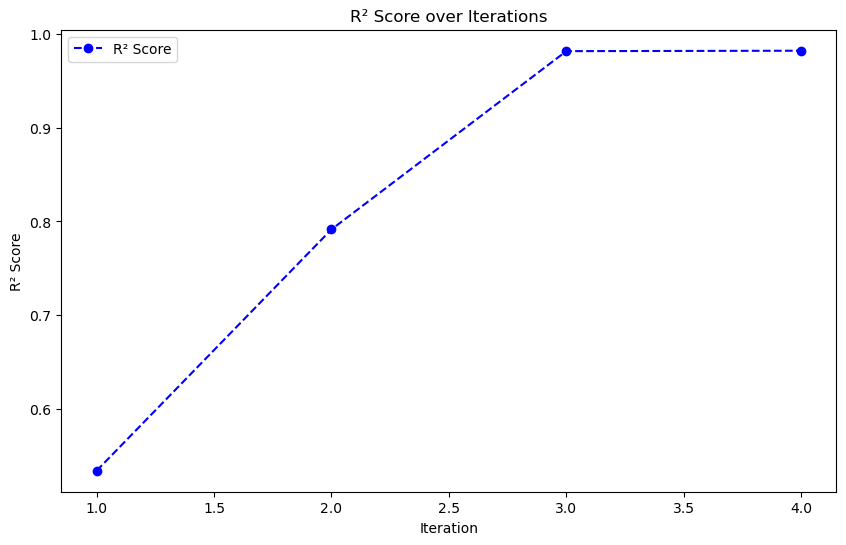

In [20]:
X_pool, y_pool = x_train, y_train
X_rest, y_rest = X_test, Y_test 
n_iterations = 4
acquisition_function = 'MPI' 

# Store R² scores for each iteration
r2_scores = []
for iteration in range(n_iterations):
    print(f"Iteration {iteration + 1}")
    
    # Perform Bayesian optimization to suggest the next parameters to test
    optimizer = run_optimization(acquisition_function)
    best_params = optimizer.X[np.argmin(optimizer.Y)]
    best_params_dict = {
        'Density':(best_params[0]),
        '2->0':(best_params[1]),
        'Catalyst amount (umol)':int(best_params[2]),
        'Melting point':int(best_params[3]),
        'pH before':(best_params[4]),
        'Electical Conductivity 10^7':(best_params[5]),
        'C':(best_params[6]),
        'gamma':(best_params[7]),
        'n_estimators': int(best_params[8]),
        'max_features': int(best_params[9]),
        'min_samples_split': int(best_params[10]),
        'Extinction coefficient':best_params[11],
        '3->0': best_params[12],
        'Extinction coefficient (400 nm)':best_params[13],
        'Max absorption wavelength':best_params[14]
    }
    
    # Simulate testing the suggested parameters (here we use the rest of the data for simulation)
    new_X, X_rest, new_y, y_rest = train_test_split(X_rest, y_rest, train_size=3, random_state=42)
    X_pool = np.vstack((X_pool, new_X))
    y_pool = np.vstack((y_pool, new_y))
    
    # Train the final model with the best parameters found
    final_model = xgb.XGBRegressor(objective='reg:squarederror', params = best_params)
    final_model.fit(X_pool, y_pool)
    final_r2 = final_model.score(X_test, Y_test)
    r2_scores.append(final_r2)
    print(f"  Best Parameters: {best_params_dict}")
    print(f"  Test R²: {final_r2:.4f}\n")
    
# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), r2_scores, 'o--', color='b', label='R² Score')
plt.xlabel('Iteration')
plt.ylabel('R² Score')
plt.title('R² Score over Iterations')
plt.legend()
plt.show()

In [21]:
optimizer = BayesianOptimization(params = best_params,f=objective_function, domain=bounds)

In [22]:
optimizer.run_optimization(max_iter=50)

In [23]:
optimized_params = optimizer.X[np.argmin(optimizer.Y)]
optimized_score = -np.min(optimizer.Y)
print(f"'Density':{(best_params[0])}, 2->0 : = {best_params[1]}, Catalyst Amount (umol): = {best_params[2]}")
print(f"Melting point: = {best_params[3]}, pH before: = {optimized_params[4]}, Electrical Conductivity 10^7: = {best_params[5]}")
print(f"C: = {optimized_params[6]}, gamma: = {optimized_params[7]}, n_estimators: = {best_params[8]}, max_features: = {best_params[9]}, min_samples_split: = {best_params[10]}")
print(f"Best cross-validated accuracy: {optimized_score}")

'Density':2.4761519917610615, 2->0 : = -0.8534263694822029, Catalyst Amount (umol): = 996.9146049103275
Melting point: = 3099.615325659546, pH before: = 13.420581211634214, Electrical Conductivity 10^7: = 23.04349905069293
C: = 6.357409991918572, gamma: = 0.8437556637630508, n_estimators: = 300.0, max_features: = 2.0, min_samples_split: = 5.0
Best cross-validated accuracy: -0.16804400411866605


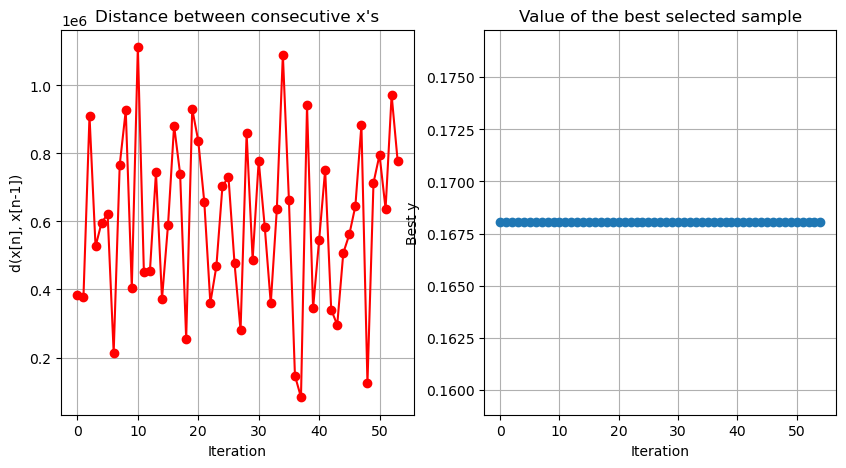

In [24]:
optimizer.plot_convergence()